<center>
<img src="../images/ods_stickers.jpg" />
    
# Inferencia Estadística 



## <center>Analizar datos de enfermedades cardiovasculares



#### Problema

Predecir la presencia o ausencia de enfermedad cardiovascular (CVD) utilizando los resultados del examen del paciente.

#### Descripción de los datos

Hay 3 tipos de variables de entrada:

- *Objective*: información objetiva ;
- *Examination*: resultados del examen medico;
- *Subjective*: Información dada por el paciente.


| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

Todos los valores del conjunto de datos se recopilaron en el momento del examen médico.



#  Parte 1. Análisis preliminar



In [1]:
# Import all required modules
import pandas as pd
import numpy as np

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import plotting modules
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

You will use the `seaborn` library for visual analysis, so let's set that up too:

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/INFERENCIA/PythonMMC

 Analizando-datos-cardiovasculares-Copy1.ipynb
 Analizando-datos-cardiovasculares-Copy2.ipynb
 data
 InfEst2021_Ejercicio01_pandas_uci_adult.ipynb
 InfEst2021_Ejercicio02_visual_titanic.ipynb
 InfEst_Telecom_churn_pandas.ipynb
 tarea1_mateomarengocano.ipynb
 tarea2_mateomarengocano.ipynb
'Trabajo Especial - Mateo Marengo Cano (1).ipynb'
'Trabajo Especial - Mateo Marengo Cano.ipynb'


In [5]:
df = pd.read_csv('/content/drive/MyDrive/INFERENCIA/PythonMMC/data/card_des.csv')
#df = pd.read_csv('data/card_des.csv')

print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0



  Convirtamos los datos en formato *long* y representemos los conteos de valores de las características categóricas usando [`factorplot()`](https://seaborn.pydata.org/generated/seaborn.factorplot.html).

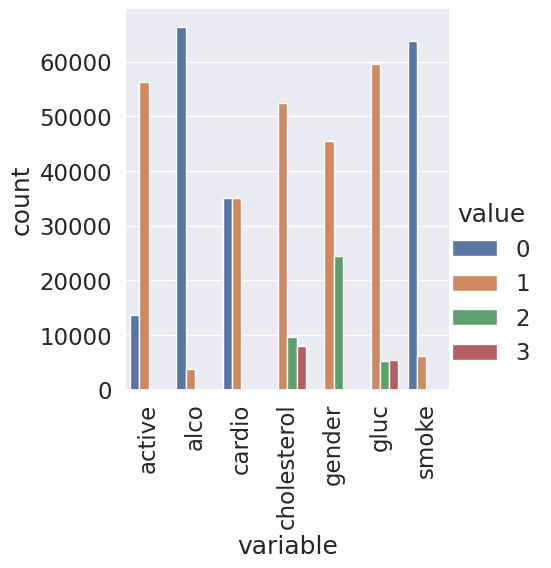

In [6]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active', 'cardio'])

df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.catplot(x='variable', y='count', hue='value', 
               data=df_uniques, kind='bar');
plt.xticks(rotation='vertical');

Podemos ver que las clases de destino están equilibradas. ¡Genial!

Dividamos el conjunto de datos por valores objetivo. ¿Puedes ya detectar la característica más significativa con solo mirar la figura?

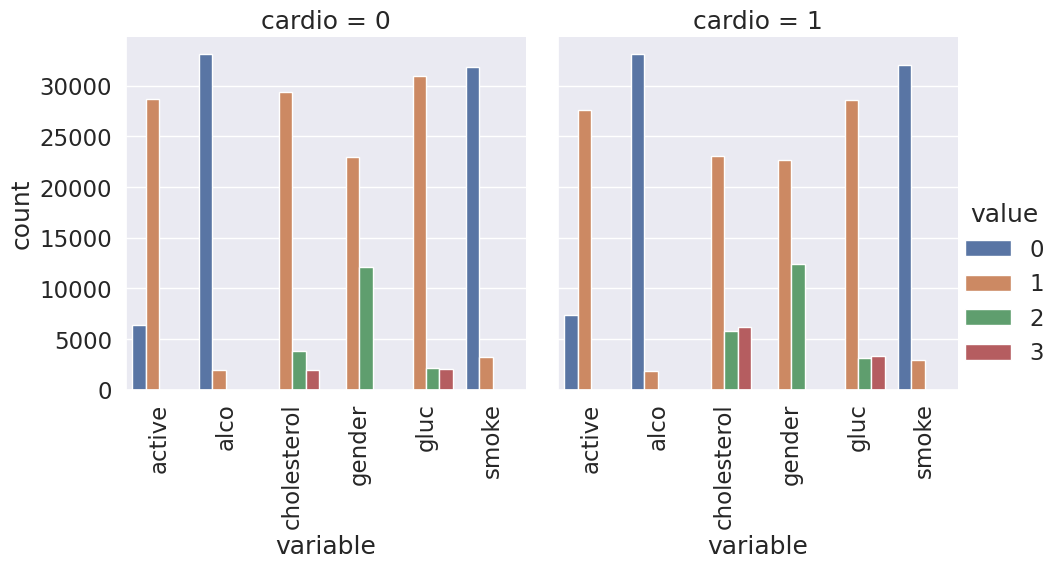

In [7]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active'], 
                     id_vars=['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value', 
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

g = sns.catplot(x='variable', y='count', hue='value', 
               col='cardio', data=df_uniques, kind='bar');
g.set_xticklabels(rotation='vertical');

Puede ver que la distribución de los niveles de colesterol y glucosa difiere mucho según el valor de la variable objetivo. ¿Es esto una coincidencia?

Ahora, calculemos algunas estadísticas para los valores únicos de las características:

In [8]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


Al final, tenemos:
- 5 características numéricas (excluyendo *id*);
- 7 características categóricas;
- 70000 registros en total.

## 1.1. Observaciones básicas


**Pregunta 1.1. (1 punto). ¿Cuántos hombres y mujeres están presentes en este conjunto de datos? No se proporcionaron los valores de la variable `gender`  (ya sea que "1" represente a mujeres o a hombres); descúbralo analizando la altura, suponiendo que los hombres son más altos en promedio.** 

1. 45530 mujeres y 24470 hombres
2. 45530 hombres y 24470 mujeres
3. 45470 mujeres y 24530 hombres
4. 45470 hombres y 24530 mujeres

In [9]:
df.groupby('gender')['height'].mean()
im = df.groupby('gender')['height'].mean().idxmax() #número de genero que representa hombres
iw = df.groupby('gender')['height'].mean().idxmin()
cm = df['gender'].value_counts()[im] #cantidad de hombres
cw = df['gender'].value_counts()[iw]

print('El género ' + str(im) + ' representa a los hombres de cuales hay ' + str(cm) + ' y el ' +
         str(iw) + ' a las mujeres de las cuales hay ' + str(cw))

El género 2 representa a los hombres de cuales hay 24470 y el 1 a las mujeres de las cuales hay 45530


**Pregunta 1.2. (1 punto). ¿Qué género reporta consumir alcohol con más frecuencia, hombres o mujeres?**
1. mujeres
2. hombres

In [10]:
df.groupby('gender')['alco'].mean()
ma = df.groupby('gender')['alco'].mean().idxmax()
print('El género ' + str(ma) + ' es el que reporta consumir alcohol con más frecuencia')

El género 2 es el que reporta consumir alcohol con más frecuencia


**Pregunta 1.3. (1 punto). ¿Cuál es la diferencia entre los porcentajes de fumadores entre hombres y mujeres (redondeado)?**
1. 4
2. 16
3. 20
4. 24

In [11]:
abs(round(df.loc[df['gender'] == 1, 'smoke'].mean()*100)-round(df.loc[df['gender'] == 2, 'smoke'].mean()*100))

20

**Pregunta 1.4. (1 punto). ¿Cuál es la diferencia entre las medianas de la de edad para fumadores y no fumadores (en meses, redondeados)? Tendrás que averiguar las unidades de la `age` de la función en este conjunto de datos.**

1. 5
2. 10
3. 15
4. 20

In [12]:
round(abs(df.groupby('smoke')['age'].median()[0]-df.groupby('smoke')['age'].median()[1])/365*12)

20

## 1.2. Mapas de riesgo


En el sitio web de la Sociedad Europea de Cardiología, se proporciona una [escala SCORE] (https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts). Se utiliza para calcular el riesgo de muerte por enfermedad cardiovascular en los próximos 10 años. Aquí lo tienes:
<img src=https://habrastorage.org/webt/ik/gx/hr/ikgxhr3w1vzqihgitgrbdorfb14.png width=30%>

Echemos un vistazo al rectángulo superior derecho, que muestra un subconjunto de hombres fumadores de 60 a 65 años. (No es obvio, pero los valores en la figura representan el límite superior).

Vemos el valor 9 en la esquina inferior izquierda del rectángulo y 47 en la esquina superior derecha. Esto significa que, para las personas de este grupo de edad y género cuya presión sistólica es inferior a 120, se estima que el riesgo de ECV es 5 veces menor que para aquellas con presión en el intervalo [160,180).

Calculemos esa misma proporción usando nuestros datos.

Aclaraciones:
- Calcular la función ``age_years``: redondear la edad al número de años más cercano. Para esta tarea, seleccione únicamente a las personas de 60 a 64 años, inclusive.
- Las categorías de niveles de colesterol difieren entre la figura y nuestro conjunto de datos. La conversión para la función ``colesterol`` es la siguiente: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

In [13]:
df['age_years'] = (df['age']/365.25).round().astype(int) #o 365.25 por los bisiestos?
df2 = df[(df['age_years']>=60) & (df['age_years']<=64)]
df2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,60
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,61
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1,62
10,15,22530,1,169,80.0,120,80,1,1,0,0,1,0,62
19,29,21755,2,162,56.0,120,70,1,1,1,0,1,0,60


**Pregunta 1.5. (2 puntos). Calcule la fracción de personas con CVD para los dos segmentos descritos anteriormente. ¿Cuál es la razón de estas dos fracciones?**

1. 1
2. 2
3. 3
4. 4

In [14]:
hfv = df2[(df2['gender'] == 2) & (df2['smoke'] == 1)] #toma el grupo del rectangulo superior derecho, hombres de mas de 60 que fuman
infizq = hfv[(hfv['cholesterol'] == 1) & (hfv['ap_hi'] < 120)]['cardio'].mean()
supder = hfv[(hfv['cholesterol'] == 3) & (hfv['ap_hi'] >= 160) & (hfv['ap_hi'] < 180)]['cardio'].mean()

round(supder/infizq)

3

## 1.3. Analizando BMI


Crear una nueva característica – BMI ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). Para ello, divide el peso en kilogramos por el cuadrado de la altura en metros. Se dice que los valores normales de IMC están entre 18,5 y 25.

In [15]:
df['BMI'] = df['weight'] / ((df['height']/100)**2)

**Pregunta 1.6. (2 puntos). Elija las declaraciones correctas:**

1. La mediana del IMC en la muestra está dentro del rango de valores normales del IMC.
2. El IMC de las mujeres es en promedio más alto que el de los hombres.
3. Las personas sanas tienen, en promedio, un IMC más alto que las personas con ECV.
4. Para los hombres sanos que no beben, el IMC está más cerca de la norma que para las mujeres sanas que no beben

In [16]:
bmimed = df['BMI'].median() #entonces la 1 es falsa
if (bmimed >= 18.5) & (bmimed <= 25):
    print('La declaración 1 es correcta')
else:
    print('La declaración 1 es incorrecta')

La declaración 1 es incorrecta


In [17]:
bmimedg = df.groupby('gender')['BMI'].median() #la 2 es verdadera
if bmimedg[1] > bmimedg[2]:
    print('La declaración 2 es correcta')
else:
    print('La declaración 2 es incorrecta')

La declaración 2 es correcta


In [18]:
bmicar = df.groupby('cardio')['BMI'].mean() #3 es falso
if bmicar[0] > bmicar[1]:
    print('La declaración 3 es correcta')
else:
    print('La declaración 3 es incorrecta')

La declaración 3 es incorrecta


In [19]:
df.loc[(df['cardio'] == 0) & (df['alco'] == 0)].groupby('gender')['BMI'].median() #4 verdadero

gender
1    25.654372
2    25.102391
Name: BMI, dtype: float64

## 1.4. Limpiando los datos

### Tarea:
Podemos ver que los datos no son perfectos. Contiene "suciedad" e inexactitudes. Veremos esto mejor a medida que visualicemos los datos.

Filtre los siguientes segmentos de pacientes (los consideramos como datos erróneos)

- diastolic pressure es más alta que systolic.
- height es estrictamente inferior al percentil 2,5 (Use `pd.Series.quantile` para calcular este valor. Si no está familiarizado con la función, lea los documentos de ayuda de pandas).
- height es estrictamente superior al percentil 97,5
- weight es estrictamente inferior al percentil 2,5
- weight es estrictamente superior al percentil 97,5

Esto no es todo lo que podemos hacer para limpiar estos datos, pero es suficiente por ahora.



In [20]:
df_borrar = df[(df['ap_lo']>df['ap_hi']) | (df['height']<df['height'].quantile(0.025)) | (df['height']>df['height'].quantile(0.975))| (df['weight']<df['weight'].quantile(0.025)) | (df['weight']>df['weight'].quantile(0.975))]

df_filtrado = df[~df.index.isin(df_borrar)]

df_filtrado.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177


**Pregunta 1.7. (2 puntos). ¿Qué porcentaje de los datos originales (redondeados) desechamos?**

1. 8
2. 9
3. 10
4. 11

In [21]:
round(df_borrar.shape[0]/df.shape[0]*100)

10

# Parte 2. Analisis visual de los datos

## 2.1. Visualización de matriz de correlación

Para comprender mejor las características, puede crear una matriz de los coeficientes de correlación entre las características. Utilice el conjunto de datos inicial (sin filtrar).

### Tarea:

Trace una matriz de correlación utilizando [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). Puede crear la matriz utilizando las herramientas estándar de `pandas` con los parámetros predeterminados.


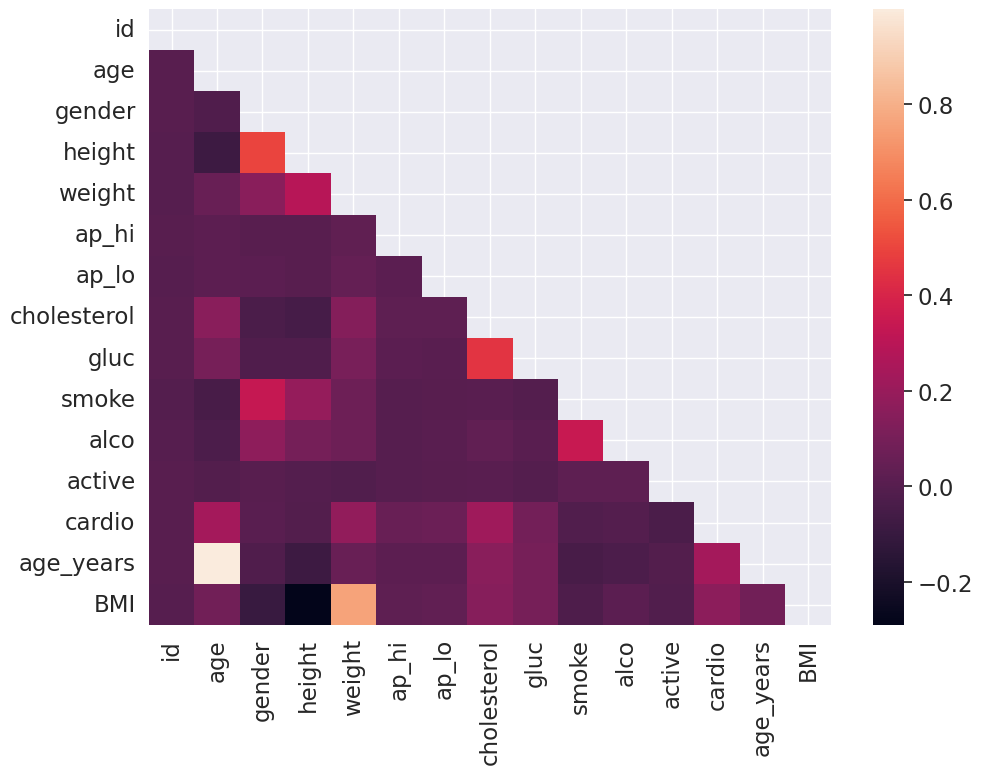

In [22]:
matcor = df.corr(method="pearson")
matcor = matcor.mask(np.triu(np.ones(matcor.shape, dtype=np.bool)))
sns.heatmap(matcor);

**Pregunta 2.1. (1 punto).** ¿Qué par de caracteristicas tienen la correlación de Pearson más fuerte con la caracteristica  *gender* ?

1. Cardio, Cholesterol
2. Height, Smoke
3. Smoke, Alco
4. Height, Weight

In [23]:
matcor['gender'].sort_values(ascending=False).index[[0,1]]

Index(['height', 'smoke'], dtype='object')

## 2.2.Distribución de altura de hombres y mujeres.

De nuestra exploración anterior de los valores únicos, sabemos que el género está codificado por los valores *1* y *2*. Aunque no conoce la correlación de estos valores con el género, puede averiguarlo gráficamente observando los valores medios de height y weight para cada valor de la variable *gender*.



### Tarea
Cree un diagrama de violín para height y gender usando [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Utilice los parámetros:
- `hue` para dividir por género;
- `scale` para evaluar el número de registros para cada género.

Para que la trama se represente correctamente, debe convertir su `DataFrame` a formato *long* usando la función `melt()` de `pandas`. Aquí hay [un ejemplo] (https://stackoverflow.com/a/41575149/3338479) de esto para su referencia.



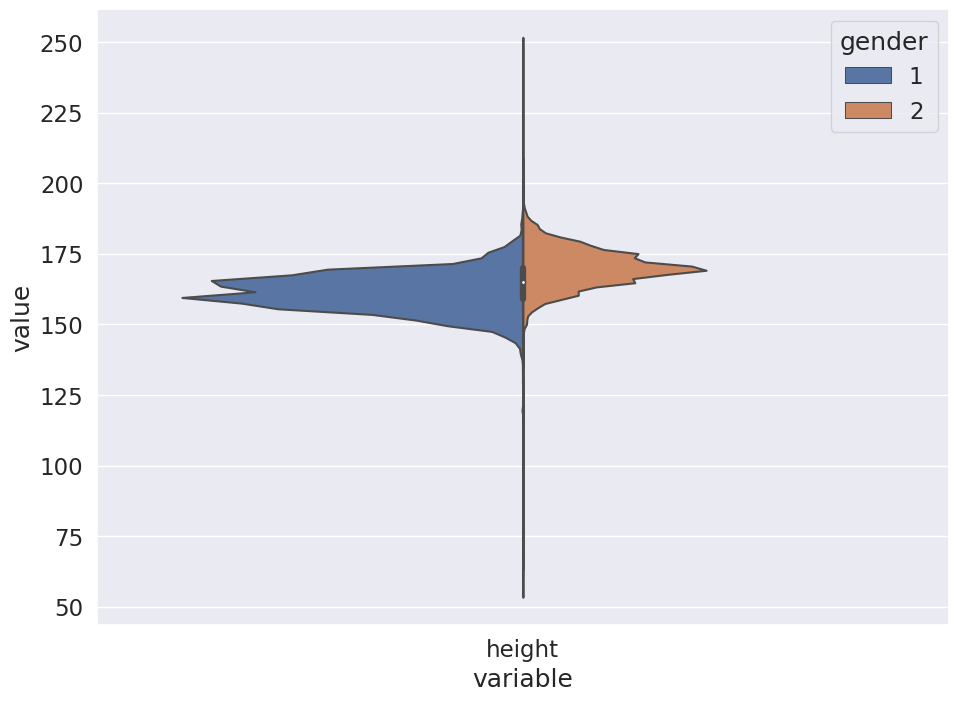

In [24]:
dflong = pd.melt(df, value_vars=['height'], id_vars=['gender'])

sns.violinplot(x='variable',y='value',hue='gender',scale='count',data=dflong,split=True);

**Pregunta 2.2. (1 punto).** ¿Qué par de características tiene la correlación de Spearman más fuerte?

1. Height, Weight
2. Age, Weight
3. Cholesterol, Gluc
4. Cardio, Cholesterol
5. Ap_hi, Ap_lo
6. Smoke, Alco

In [25]:
df = pd.read_csv('/content/drive/MyDrive/INFERENCIA/PythonMMC/data/card_des.csv')
#df = pd.read_csv('data/card_des.csv') #para que no aparezca el bmi

matcor2 = df.corr(method='spearman')
matcor2[matcor2<1].max().sort_values(ascending=False).index[[0,1]]

Index(['ap_hi', 'ap_lo'], dtype='object')

## 2.3. Correlación de rangos

En la mayoría de los casos, *el coeficiente de correlación lineal de Pearson* es más que suficiente para descubrir patrones en los datos.
Pero avancemos un poco más y calculemos una [correlación de rango](https://en.wikipedia.org/wiki/Rank_correlation). Nos ayudará a identificar esos pares de características en los que el rango más bajo en la serie variacional de una característica siempre precede al rango más alto en la otra (y tenemos lo contrario en el caso de correlación negativa).

### Tarea

Calcule y trace una matriz de correlación utilizando el [Spearman's rank correlation coefficient] (https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coficient).


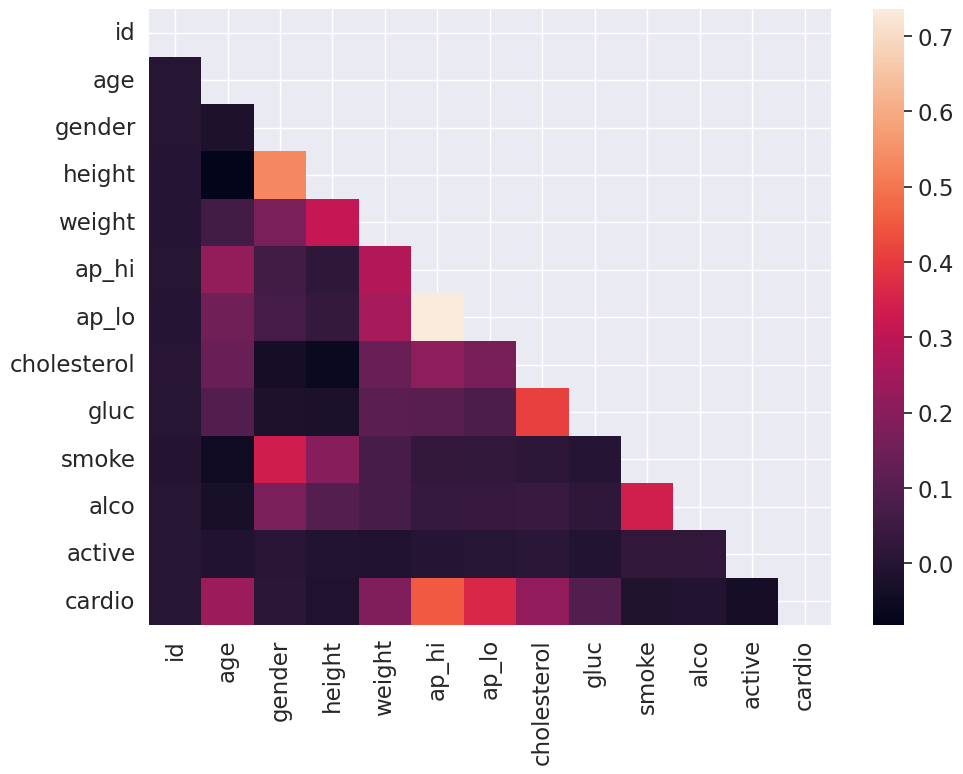

In [26]:
matcor2 = matcor2.mask(np.triu(np.ones(matcor2.shape, dtype=np.bool)))
sns.heatmap(matcor2);

**Pregunta 2.3. (1 punto).** ¿Por qué estas características tienen una fuerte correlación de rango?

1. Inexactitudes en los datos (errores de adquisición de datos).
2. La relación es incorrecta, estas características no deben estar relacionadas.
3. Naturaleza de los datos.

In [27]:
print('Por la naturaleza de los datos')

Por la naturaleza de los datos


## 2.4. Age

Previamente, calculamos la edad de los encuestados en años al momento del examen.

### Tarea

Cree un *count plot* usando [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) con la edad en el eje *X* y el número de personas en el * eje Y*. Su gráfico resultante debe tener dos columnas para cada edad, correspondientes al número de personas para cada clase de *cardio* de esa edad.

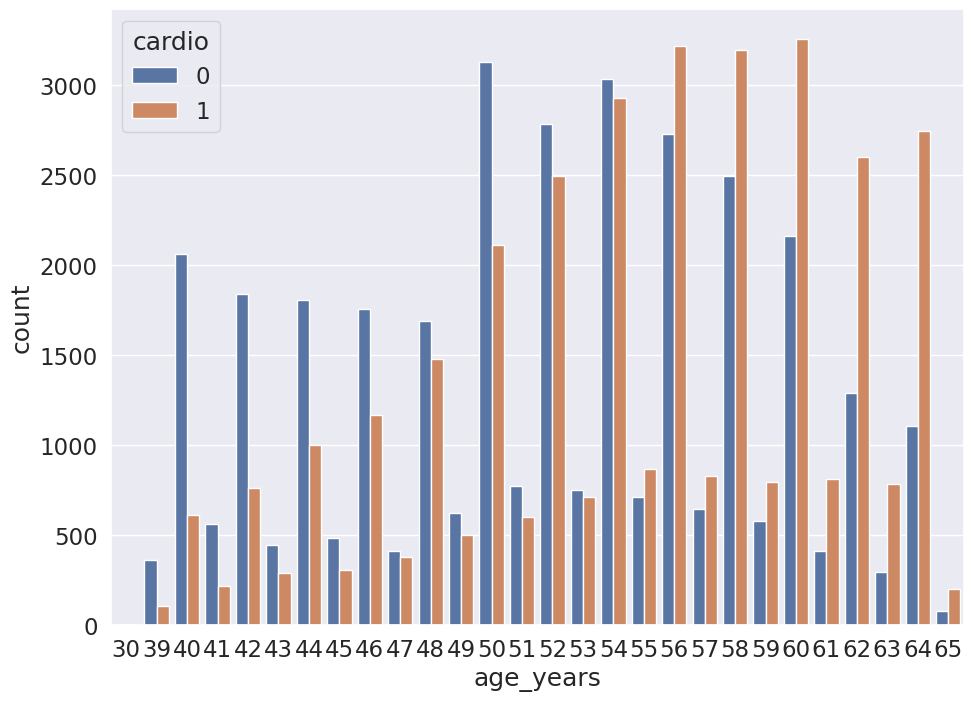

In [28]:
df['age_years'] = (df['age']/365.25).round().astype(int)
sns.countplot(df, x='age_years', hue='cardio');

**Pregunta 2.4. (1 punto).** ¿Cuál es la edad mínima a la que el número de personas con ECV supera al número de personas sin ECV?

1. 44
2. 55
3. 64
4. 70

In [29]:
#ac = df.groupby('age_years')['cardio'].value_counts()

for age in sorted(df['age_years'].unique().tolist()):
    a = df.loc[df['age_years']==age,'cardio'].value_counts()
    if a.shape[0]==2:
        if a[0] < a[1]:
            print(age)
            break

55
